# Deep Learning - Getting Started

## Multi-class image classification (MNIST dataset - Hello World of deep learning)
The task is to classify grayscale images of handwritten digits (28 × 28 pixels) into their 10 categories (0 through 9). We’ll use the MNIST dataset, a classic in the machine-learning community, which has been around almost as long as the field itself and has been intensively studied. It’s a set of 60,000 training images, plus 10,000 test images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s.

In [1]:
# Important to work with tensorflow version 1
%tensorflow_version 1.x 
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
(60000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]


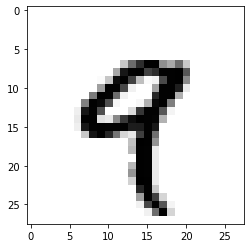

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/2
60000/60000 [==============================] - 5s 83us/step - loss: 0.2554 - accuracy: 0.9257
Epoch 2/2
60000/60000 [==============================] - 3s 53us/step
test_acc: 0.9777666926383972


In [2]:
import matplotlib.pyplot as plt
from keras import models
from keras import layers

# Getting the data and looking into it
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() # This function returns a nested tuple which is assinged to 4 variables
print(train_images.shape)
print(train_labels[:10])
digit = train_images[4] # Same as train_images[4,:,:]
plt.imshow(digit, cmap = plt.cm.binary) # printing a digit
plt.show()

# Reshaping the data
train_images = train_images.reshape((60000, 28 * 28)) # Changing from 60K samples with 28 rows x 28 cols to 60K samples with 784 rows x 1 col
train_images = train_images.astype('float32') / 255   # Bringing the value between 0 and 1 using min-max logic, the min value is 0 and max value 255, so value - min / (max - min)
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

# Creating the categorical variable of each class through one-hot encoding
""" This will create a column for each of the class and mark it 0 for all but 1 for the class this is a part of. 
The number of categories should match the number of nodes in final layer. See binary classification example below for details"""
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)           
test_labels = to_categorical(test_labels)

# Building the sequential network
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,))) # Relu is max(0, value)
network.add(layers.Dense(10, activation='softmax'))
network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the network
network.fit(train_images, train_labels, epochs=2, batch_size=128) # batch is always a power of 2 (usually 32) and defines the number of samples on which the algo runs before updating weights. Epoch is the number of iterations.

# Evaluating the network on test data
test_loss, test_acc = network.evaluate(train_images, train_labels)
print('test_acc:', test_acc)


## Regression
Predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on.

In [3]:
# Getting the dataset and looking into it
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
print(train_data.shape)
print(train_targets[0:10])

# Normalizing with a mean of 0 and standard deviation of 1 (normal distribution)
mean = train_data.mean(axis=0) # axis = 0 means rows i.e. mean across all the rows of the column for all columns
std = train_data.std(axis=0)
train_data -= mean 
train_data /= std
test_data -= mean # Note, how we used the mean of test data here.
test_data /= std

# Building the model as a function because we’ll need to instantiate the same model multiple times
from keras import models
from keras import layers

def build_model():
  model = models.Sequential() 
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],))) 
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) 
  return model

57344/57026 [==============================] - 0s 1us/step
(404, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


In [ ]:
# Doing k-fold cross validation as the data set is very small (404 rows only)
import numpy as np
k=4 # folds
num_val_samples = len(train_data) // k # '//' is the floor operator
num_epochs = 300
all_mae_histories = []
all_scores = []

for i in range(k):
  print('processing fold:', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate( [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

  model = build_model()
  """ Note that the call to model.fit() returns a History object. This object has a member history, which is a dictionary containing data about everything that happened during training. 
      history_dict = history.history
      history_dict.keys()"""
  history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0) # Trains the model in silent mode
  mae_history = history.history['mae'] 
  all_mae_histories.append(mae_history) # saving the mae across each epoch from 1 to 300 for each fold to see later what epoch values keeps the MAE the lowest

  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0) # Evaluation is done on the validation dataset and not on the test
  all_scores.append(val_mae)

print(all_scores)
print(np.mean(all_scores))

# average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_mae_history = (np.array(all_mae_histories))
average_mae_history = average_mae_history.mean(axis=0)
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show() # We see that as the epochs increase the MAE decrease, this shouldn't be the case however as with higher epochs the model should start overfitting. Will investigate later.

# final model (based on learnings on how many epochs to choose and a bigger batch size)
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score) # how much $ on an average the prediction is off.

# Generate predictions
print(model.predict(test_data[10:12])) # predictions for 2 samples
print(model.predict(test_data[[10]]))  # prediction for 1 sample. Note the double square brackets. 

help(model.fit) # function to use to get details of a function (like ? in R language)


## Binary classification

The objective is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.
Based on [this](https://www.bmc.com/blogs/keras-neural-network-classification/) article. Data has been sourced from the Kaggle dataset [here](https://www.kaggle.com/uciml/pima-indians-diabetes-database?select=diabetes.csv).

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  ...         Age     Outcome
count   768.000000  768.000000  ...  768.000000  768.000000
mean      3.845052  120.894531  ...   33.240885    0.348958
std       3.369578   31.972618  ...   11.760232    0.47

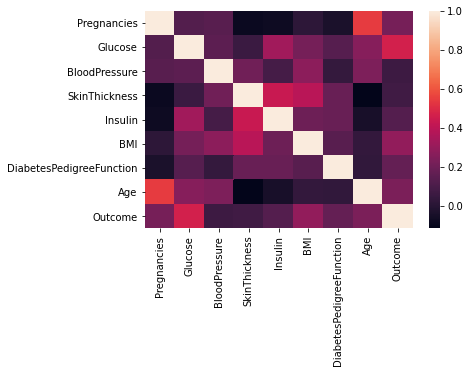

In [5]:
# Importing the pandas package
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

# Loading the datasets as Pandas Dataframe
data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv')
print(data.info())     # Inspect the values of the dataframe     
print(data.describe()) # summary statistics of the dataframe
print(data.head(20))   # Visually inspect some rows

# Check correlation 
data['BloodPressure'].corr( data["BMI"]) # correlation of 1 variable with another 
corr = data.corr()                       # correlation of all variables against one another
print(corr)
sns.heatmap(corr,                        # Plotting the correlation heat map
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [6]:
# Splitting the dataset into training and test datasets
features = data.iloc[:,0:8]   # Getting all the features
labels = data['Outcome']      # Getting the target variable

from sklearn.model_selection import train_test_split
X = features
y = np.ravel(labels)          # To get a flattened 1D array
train_data, test_data, train_targets, test_targets = train_test_split(X, y, test_size=0.33, random_state=42) 

# Normalizing the datasets
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_data) 
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)  # The training data fit is also used for test data. Never do any standartization with the mean and stds or any other measure from test data. Use training ones always.

print(train_data[:10]) # checking how the normalization looks like. Columns are removed as dataset is a numpy n-dimensional array now.


[[ 1.89917664e+00 -1.94750933e-01  1.55717838e+00 -1.32537379e+00
  -6.85859549e-01 -1.04293476e+00  1.60661512e+00  6.90585855e-02]
 [ 9.82865509e-01  6.40463359e-01 -5.54961074e-01  8.05525757e-01
   9.58734921e-01 -4.14806202e-01  6.26098151e-01  2.37289284e+00]
 [ 6.65543754e-02 -1.63817070e-01  1.12030334e-01 -5.50501227e-01
   6.71916029e-02 -1.29156898e+00 -2.95311052e-02  3.25040169e-01]
 [-8.49756758e-01  1.45521556e-01 -5.54961074e-01 -1.32537379e+00
  -6.85859549e-01 -2.44688051e-01 -3.63199566e-01  1.17831211e+00]
 [-2.38882669e-01 -1.33930385e+00  8.65099101e-04 -1.32537379e+00
  -6.85859549e-01  6.93762291e-02 -5.94425956e-01  4.95694558e-01]
 [-8.49756758e-01 -6.89692736e-01 -6.66126308e-01 -6.79646654e-01
  -6.85859549e-01 -8.59730598e-01  2.28037531e-01 -1.04019494e+00]
 [-8.49756758e-01  6.71397222e-01  7.79021741e-01  1.59798622e-01
   1.99742617e+00  1.36489138e+00  1.76466860e+00 -9.54867749e-01]
 [-8.49756758e-01  2.07389282e-01  1.00135221e+00  1.19296204e+00
   

In [7]:
# Impact of target variable treatment
"""Note: If we pass in targets as a 1D array then the last layer will have 1 node, activation as sigmoid and loss as binary crossentropy, 
else if we change target to categorical to make it a 2 column target, last layer will have 2 nodes, activation function as softmax and loss and categorical crossentropy."""
print(train_targets.shape)
temp = to_categorical(train_targets)
temp.shape

(514,)


(514, 2)

In [8]:
# Building model with target variable as 1D array - treating as binary classification
from keras import models
from keras import layers

# Building the sequential network
network = models.Sequential()
network.add(layers.Dense(32, activation='relu', input_shape=(8,))) 
network.add(layers.Dense(8, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))
network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the network
network.fit(train_data, train_targets, epochs=20, batch_size=64) 

# Evaluating the network on test data
test_loss, test_acc = network.evaluate(test_data, test_targets)
print('test_acc:', test_acc)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
514/514 [==============================] - 0s 298us/step - loss: 0.7025 - accuracy: 0.5759
Epoch 2/20
514/514 [==============================] - 0s 32us/step - loss: 0.6711 - accuracy: 0.6245
Epoch 3/20
514/514 [==============================] - 0s 29us/step - loss: 0.6459 - accuracy: 0.6634
Epoch 4/20
514/514 [==============================] - 0s 27us/step - loss: 0.6271 - accuracy: 0.6946
Epoch 5/20
514/514 [==============================] - 0s 31us/step - loss: 0.6088 - accuracy: 0.7062
Epoch 6/20
514/514 [==============================] - 0s 31us/step - loss: 0.5928 - accuracy: 0.7140
Epoch 7/20
514/514 [==============================] - 0s 32us/step - loss: 0.5769 - accuracy: 0.7140
Epoch 8/20
514/514 [==============================] - 0s 31us/step - loss: 0.5621 - accuracy: 0.7198
Epoch 9/20
514/514 [==============================] - 0s 33us/step - loss: 0.5490 - accuracy: 0.7

In [9]:
# Building model with target variable as 2D array - treating as multiclass classification
from keras import models
from keras import layers

# Changing the target variables from 1D to 2D (1 variable for each class through 1 hot encoding)
train_targets_cat = to_categorical(train_targets)
test_targets_cat = to_categorical(test_targets)

# Building the sequential network
network = models.Sequential()
network.add(layers.Dense(32, activation='relu', input_shape=(8,))) 
network.add(layers.Dense(8, activation='relu'))
network.add(layers.Dense(2, activation='softmax'))
network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the network
network.fit(train_data, train_targets_cat, epochs=20, batch_size=64) 

# Evaluating the network on test data
test_loss, test_acc = network.evaluate(test_data, test_targets_cat)
print('test_acc:', test_acc)

Epoch 1/20
514/514 [==============================] - 0s 231us/step - loss: 0.6663 - accuracy: 0.6479
Epoch 2/20
514/514 [==============================] - 0s 31us/step - loss: 0.6508 - accuracy: 0.6479
Epoch 3/20
514/514 [==============================] - 0s 34us/step - loss: 0.6362 - accuracy: 0.6498
Epoch 4/20
514/514 [==============================] - 0s 30us/step - loss: 0.6231 - accuracy: 0.6498
Epoch 5/20
514/514 [==============================] - 0s 39us/step - loss: 0.6101 - accuracy: 0.6518
Epoch 6/20
514/514 [==============================] - 0s 30us/step - loss: 0.5989 - accuracy: 0.6498
Epoch 7/20
514/514 [==============================] - 0s 30us/step - loss: 0.5882 - accuracy: 0.6556
Epoch 8/20
514/514 [==============================] - 0s 38us/step - loss: 0.5774 - accuracy: 0.6576
Epoch 9/20
514/514 [==============================] - 0s 30us/step - loss: 0.5675 - accuracy: 0.6634
Epoch 10/20
514/514 [==============================] - 0s 30us/step - loss: 0.5576 - accur